In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#import important libraries
import numpy as np
import pandas as pd
import tensorflow as tf
tf.keras.preprocessing.image.ImageDataGenerator.flow_from_dataframe?
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.vgg16 import VGG16
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_classes_df = pd.read_csv('../input/planets-dataset/planet/planet/train_classes.csv')
train_classes_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [4]:
!ls ../input/planets-dataset/planet/planet/train-jpg | wc -l

40479


In [5]:
sample_submission_df = pd.read_csv('../input/planets-dataset/planet/planet/sample_submission.csv')
sample_submission_df.head()

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water


In [6]:
test1 = !ls ../input/planets-dataset/planet/planet/test-jpg | wc -l
test2 = !ls ../input/planets-dataset/test-jpg-additional/test-jpg-additional | wc -l
assert sample_submission_df.shape[0] == float(test1[0])+float(test2[0])

In [7]:
test1

['40669']

In [8]:
test2

['20522']

In [9]:
image_number =3
img = io.imread('../input/planets-dataset/planet/planet/train-jpg/train_{}.jpg'.format(image_number))
img.shape

(256, 256, 3)

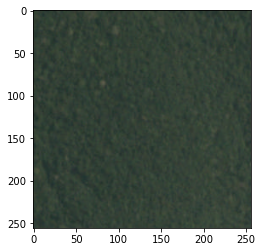

In [10]:
plt.imshow(img)

In [11]:
train_classes_df[train_classes_df['image_name'] == 'train_3']

,image_name,tags
3,train_3,clear primary


In [12]:
unique_labels = set()
def append_labels(tags):
    for tag in tags.split():
        unique_labels.add(tag)

train_classes = train_classes_df.copy()
train_classes['tags'].apply(append_labels)
unique_labels = list(unique_labels)
print(unique_labels)

['cloudy', 'primary', 'haze', 'blow_down', 'road', 'selective_logging', 'blooming', 'habitation', 'cultivation', 'partly_cloudy', 'water', 'bare_ground', 'conventional_mine', 'agriculture', 'clear', 'artisinal_mine', 'slash_burn']


In [13]:
len(unique_labels)

17

In [14]:
assert len(train_classes['image_name'].unique()) == train_classes.shape[0]

In [15]:
# let's one hot encode the labels in 'train_classes'
for tag in unique_labels:
    train_classes[tag] = train_classes['tags'].apply(lambda x: 1 if tag in x.split() else 0)
    
# adding '.jpg' extension to 'image_name'
train_classes['image_name'] = train_classes['image_name'].apply(lambda x: '{}.jpg'.format(x)) 
train_classes.head()

,image_name,tags,cloudy,primary,haze,blow_down,road,selective_logging,blooming,habitation,cultivation,partly_cloudy,water,bare_ground,conventional_mine,agriculture,clear,artisinal_mine,slash_burn
0,train_0.jpg,haze primary,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1.jpg,agriculture clear primary water,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0
2,train_2.jpg,clear primary,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,train_3.jpg,clear primary,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,train_4.jpg,agriculture clear habitation primary road,0,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0


In [16]:
y_col = list(train_classes.columns[2:]) # storing the tags column names as a variable

# initializing an image generator with some data augumentation
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# loading images from dataframe
X = image_gen.flow_from_dataframe(dataframe=train_classes, \
        directory='/kaggle/input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col=y_col, \
       target_size=(128, 128), class_mode='raw', seed=1, batch_size=128)

Found 40479 validated image filenames.


In [17]:
#40479 / 128 is 316 remainder 31 each image is of shape (128, 128, 3), each label is of shape (17, )

# let's abitrarily view an image
x109 = X[0][0][109] # first batch, images, 109th image
y109 = X[0][1][109] # first batch, labels, 109th label
print("each image's shape is {}".format(x109.shape))
print("each label's shape is {}".format(y109.shape))
print('we have {} batches'.format(len(X)))
print('each batch has {} images/labels'.format(X[0][0].shape[0]))
print('40479/128 is {:.2F}, so the last batch will have {} images/labels'.format(40479/128, X[316][0].shape[0]))

each image's shape is (128, 128, 3)
each label's shape is (17,)
we have 317 batches
each batch has 128 images/labels
40479/128 is 316.24, so the last batch will have 31 images/labels


In [18]:
def fbeta(ytrue , ypred, beta=2, epsilon=1e-4):
    beta_squarred = beta**2

    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(0.5)), tf.float32)
        
    tp = tf.reduce_sum(ytrue * ypred, axis=1)
    fp = tf.reduce_sum(ypred, axis=1) - tp
    fn = tf.reduce_sum(ytrue, axis=1) - tp
    
    precision = tp/(tp+fp+epsilon)
    recall = tp/(tp+fn+epsilon)
    
    fb = (1+beta_squarred)*precision*recall / (beta_squarred*precision + recall + epsilon)
    return fb

In [19]:
def multi_label_acc(ytrue , ypred, epsilon=1e-4):
    
    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(tf.greater(tf.cast(ypred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(ytrue * ypred, axis=1)
    fp = tf.reduce_sum(ypred, axis=1) - tp
    fn = tf.reduce_sum(ytrue, axis=1) - tp
    
    ytrue = tf.cast(ytrue, tf.bool)
    ypred = tf.cast(ypred, tf.bool)
    
    tn = tf.reduce_sum(tf.cast(tf.logical_not(ytrue), tf.float32) * tf.cast(tf.logical_not(ypred), tf.float32),\
                       axis=1)
    
    return (tp+tn)/(tp+tn+fp+fn+epsilon)

def build_vggmodel():
    base_model = VGG16(include_top=False,
                   weights='imagenet',
                   input_shape=(128, 128, 3), classifier_activation=None)
    model = Sequential()

    model.add(BatchNormalization(input_shape=(128, 128, 3)))


    model.add(base_model)
    model.add(Flatten())
    model.add(Dropout(0.5))

    model.add(Dense(17, activation='sigmoid'))
    opt = SGD(lr=0.01)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[multi_label_acc, fbeta])
    
    return model

In [20]:
def build_rsnetmodel():
    base_model =tf.keras.applications.ResNet152( 
                    include_top=False,
                    weights="imagenet",
                    input_shape=(128, 128, 3),
                    pooling=max)
    model = Sequential()

    model.add(BatchNormalization(input_shape=(128, 128, 3)))


    model.add(base_model)
    model.add(Flatten())
    model.add(Dropout(0.5))

    model.add(Dense(17, activation='sigmoid'))
    opt = SGD(lr=0.01)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[multi_label_acc, fbeta])
    
    return model

save_best_check_point = ModelCheckpoint(filepath='best_vggmodel.hdf5', monitor='val_fbeta', \
                                        mode='max', save_best_only=True, save_weights_only=True)

In [21]:
save_best_check_point2 = ModelCheckpoint(filepath='best_rsnetmodel.hdf5', monitor='val_fbeta', \
                                        mode='max', save_best_only=True, save_weights_only=True)

In [22]:
train_image_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,validation_split=0.2)

# generating the 80% training image data
train_gen = train_image_gen.flow_from_dataframe(dataframe=train_classes, \
        directory='../input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col=y_col, \
       target_size=(128, 128), class_mode='raw', seed=0, batch_size=128, subset='training')

# generating the 20% validation image data
val_gen = train_image_gen.flow_from_dataframe(dataframe=train_classes, \
        directory='../input/planets-dataset/planet/planet/train-jpg/', x_col='image_name', y_col=y_col, \
       target_size=(128, 128), class_mode='raw', seed=0, batch_size=128, subset='validation')

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [23]:
# setting step size for training and validation image data
step_train_size = int(np.ceil(train_gen.samples / train_gen.batch_size))
step_val_size = int(np.ceil(val_gen.samples / train_gen.batch_size))

In [24]:
step_train_size+step_val_size

317

turn on GPU

vgg_model = build_vggmodel() # building a sequential model for training

# fitting the model
vgg_model.fit(x=train_gen, steps_per_epoch=step_train_size, validation_data=val_gen, validation_steps=step_val_size,
         epochs=15, callbacks=[save_best_check_point])

In [ ]:
rsnet_model = build_rsnetmodel() # building a sequential model for training

# fitting the model
rsnet_model.fit(x=train_gen, steps_per_epoch=step_train_size, validation_data=val_gen, validation_steps=step_val_size,
         epochs=20, callbacks=[save_best_check_point2])

234700800/234698864 [==============================] - 2s 0us/step
Epoch 1/20
253/253 [==============================] - 177s 701ms/step - loss: 0.2383 - multi_label_acc: 0.9206 - fbeta: 0.7777 - val_loss: 2.0024 - val_multi_label_acc: 0.8774 - val_fbeta: 0.3824
Epoch 2/20
253/253 [==============================] - 162s 642ms/step - loss: 0.1485 - multi_label_acc: 0.9469 - fbeta: 0.8409 - val_loss: 0.5249 - val_multi_label_acc: 0.8342 - val_fbeta: 0.1948
Epoch 3/20
253/253 [==============================] - 162s 642ms/step - loss: 0.1301 - multi_label_acc: 0.9527 - fbeta: 0.8573 - val_loss: 0.2292 - val_multi_label_acc: 0.9225 - val_fbeta: 0.6745
Epoch 4/20
253/253 [==============================] - 162s 641ms/step - loss: 0.1179 - multi_label_acc: 0.9564 - fbeta: 0.8688 - val_loss: 0.1267 - val_multi_label_acc: 0.9552 - val_fbeta: 0.8472
Epoch 5/20
253/253 [==============================] - 162s 641ms/step - loss: 0.1096 - multi_label_acc: 0.9592 - fbeta: 0.8768 - val_loss: 0.1168 - v

vgg_model2 = build_vggmodel() # building a sequential model for testing

#loading in the weights of the trained model
vgg_model2.load_weights('best_vggmodel.hdf5')

In [ ]:
rsnet_model2 = build_rsnetmodel() # building a sequential model for training
 # building a sequential model for testing

#loading in the weights of the trained model
rsnet_model2.load_weights('best_rsnetmodel.hdf5')

In [ ]:
# adding .jpg extension to 'image_name' in sample_submission data
sample_submission = sample_submission_df.copy()
sample_submission['image_name'] = sample_submission['image_name'].apply(lambda x: '{}.jpg'.format(x))
sample_submission.head()

In [ ]:
# selecting the first 40669 'image_name'(s) from the submission_sample dataframe to generate image data from 
# test.jpg folder
test1_df = sample_submission.iloc[:40669]['image_name'].reset_index().drop('index', axis=1)
test1_df.head()

In [ ]:
test1_df.shape

In [ ]:
# initializing an image data generator object for the first 40669 images in the sample submission dataframe
test_image_gen1 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# generating the image data for the first 40669 images in the sample submission dataframe
test_gen1 = test_image_gen1.flow_from_dataframe(dataframe=test1_df, \
            directory='../input/planets-dataset/planet/planet/test-jpg/', x_col='image_name', y_col=None, \
            batch_size=128, shuffle=False, class_mode=None, target_size=(128, 128))

# setting the step size for the testing set for the first 40669 images in the sample submission dataframe
step_test_size1 = int(np.ceil(test_gen1.samples / test_gen1.batch_size))

test_gen1.reset() # reseting the generator to be sure of avoiding shuffling
vgg_pred1 = vgg_model2.predict(test_gen1, steps=step_test_size1, verbose=1) # predicts the first 40669 images in the 
                                                                    # sample submission dataframe

In [ ]:
test_gen1.reset() # reseting the generator to be sure of avoiding shuffling
rsnet_pred1 = rsnet_model2.predict(test_gen1, steps=step_test_size1, verbose=1) # predicts the first 40669 images in the 
                                                                    # sample submission dataframe

test_file_names1 = test_gen1.filenames # storing the filenames (images names) of the first 40669 images names in 
                                       # the sample submission dataframe as ordered in the prediction as a 
                                       # variable
        
# converting the predictions of the first 40669 to tag names
vgg_pred_tags1 = pd.DataFrame(vgg_pred1)
vgg_pred_tags1 = vgg_pred_tags1.apply(lambda x: ' '.join(np.array(unique_labels)[x > 0.5]), axis=1)

# converting the predictions of the first 40669 to a dataframe
vgg_result1 = pd.DataFrame({'image_name': test_file_names1, 'tags': vgg_pred_tags1})
vgg_result1.head()

In [ ]:
test_file_names1 = test_gen1.filenames # storing the filenames (images names) of the first 40669 images names in 
                                       # the sample submission dataframe as ordered in the prediction as a 
                                       # variable
        
# converting the predictions of the first 40669 to tag names
rsnet_pred_tags1 = pd.DataFrame(rsnet_pred1)
rsnet_pred_tags1 = rsnet_pred_tags1.apply(lambda x: ' '.join(np.array(unique_labels)[x > 0.5]), axis=1)

# converting the predictions of the first 40669 to a dataframe
rsnet_result1 = pd.DataFrame({'image_name': test_file_names1, 'tags': rsnet_pred_tags1})
rsnet_result1.head()

In [ ]:
# selecting the remaining 'image_name'(s) from the submission_sample dataframe to generate image data from 
# test-additional.jpg folder
test2_df = sample_submission.iloc[40669:]['image_name'].reset_index().drop('index', axis=1)
test2_df.head()

In [ ]:
# initializing an image data generator object for the remaining images in the sample submission dataframe
test_image_gen2 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

# generating the image data for the remaining images in the sample submission dataframe
test_gen2 = test_image_gen2.flow_from_dataframe(dataframe=test2_df, \
            directory='../input/planets-dataset/test-jpg-additional/test-jpg-additional/', x_col='image_name', \
            y_col=None, batch_size=128, shuffle=False, class_mode=None, target_size=(128, 128))

# setting the step size for the testing set for the remaining images in the sample submission dataframe
step_test_size2 = int(np.ceil(test_gen2.samples / test_gen2.batch_size))

test_gen2.reset() # reseting the generator to be sure of avoiding shuffling
vgg_pred2 = vgg_model2.predict(test_gen2, steps=step_test_size2, verbose=1) # predicts the remaining images in the 
                                                                    # sample submission dataframe

In [ ]:
test_gen2.reset() # reseting the generator to be sure of avoiding shuffling
rsnet_pred2 = rsnet_model2.predict(test_gen2, steps=step_test_size2, verbose=1) # predicts the remaining images in the 
                                                                    # sample submission dataframe

test_file_names2 = test_gen2.filenames # storing the filenames (images names) of the remaining images names in 
                                       # the sample submission dataframe as ordered in the prediction as a 
                                       # variable
        
# converting the predictions of the remaining images to tag names
vgg_pred_tags2 = pd.DataFrame(vgg_pred2)
vgg_pred_tags2 = vgg_pred_tags2.apply(lambda x: ' '.join(np.array(unique_labels)[x > 0.5]), axis=1)

# converting the predictions of the remaining to a dataframe
vgg_result2 = pd.DataFrame({'image_name': test_file_names2, 'tags': vgg_pred_tags2})
vgg_result2.head()

In [ ]:
test_file_names2 = test_gen2.filenames # storing the filenames (images names) of the remaining images names in 
                                       # the sample submission dataframe as ordered in the prediction as a 
                                       # variable
        
# converting the predictions of the remaining images to tag names
rsnet_pred_tags2 = pd.DataFrame(rsnet_pred2)
rsnet_pred_tags2 = rsnet_pred_tags2.apply(lambda x: ' '.join(np.array(unique_labels)[x > 0.5]), axis=1)

# converting the predictions of the remaining to a dataframe
rsnet_result2 = pd.DataFrame({'image_name': test_file_names2, 'tags': rsnet_pred_tags2})
rsnet_result2.head()

vgg_final_result = pd.concat([vgg_result1, vgg_result2]) # concatenate the predictions of the test.jpg and 
                                             # test-additional.jpg into a single dataframe
    
vgg_final_result = vgg_final_result.reset_index().drop('index', axis=1) # reseting the index of the dataframe so it 
                                                                # matches that of sample submission datafarme

print(vgg_final_result.shape)
vgg_final_result.head()

In [ ]:
rsnet_final_result = pd.concat([rsnet_result1, rsnet_result2]) # concatenate the predictions of the test.jpg and 
                                             # test-additional.jpg into a single dataframe
    
rsnet_final_result = rsnet_final_result.reset_index().drop('index', axis=1) # reseting the index of the dataframe so it 
                                                                # matches that of sample submission datafarme

print(rsnet_final_result.shape)
rsnet_final_result.head()

# confirming that the predicted images are ordered as in sample submission dataframe
assert sum(sample_submission['image_name'] == vgg_final_result['image_name']) == 61191

In [ ]:
# confirming that the predicted images are ordered as in sample submission dataframe
assert sum(sample_submission['image_name'] == rsnet_final_result['image_name']) == 61191

# removing the .jpg extension from 'image_name' column
vgg_final_result['image_name'] = vgg_final_result['image_name'].apply(lambda x: x[:-4])
vgg_final_result.head()

In [ ]:
# removing the .jpg extension from 'image_name' column
rsnet_final_result['image_name'] = rsnet_final_result['image_name'].apply(lambda x: x[:-4])
rsnet_final_result.head()

vgg_final_result.to_csv('vggsubmission.csv', index=False) # saving the predictions

In [ ]:
rsnet_final_result.to_csv('resnetsubmission1.csv', index=False) # saving the predictions